# Notebook adopted from `Roboflow` tutorials
https://github.com/roboflow/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb

# Segment Anything Model (SAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything) [![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)

Segment Anything Model (SAM): a new AI model from Meta AI that can "cut out" any object, in any image, with a single click. SAM is a promptable segmentation system with zero-shot generalization to unfamiliar objects and images, without the need for additional training. This notebook is an extension of the [official notebook](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) prepared by Meta AI.

![segment anything model](https://media.roboflow.com/notebooks/examples/segment-anything-model-paper.png)


## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- **Before you start** - Make sure you have access to the GPU
- Install Segment Anything Model (SAM)
- Download Example Data
- Load Model
- Automated Mask Generation
- Generate Segmentation with Bounding Box
- Segment Anything in Roboflow Universe Dataset

## Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri May  5 12:52:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant. 

In [2]:
import os
from pathlib import Path

HOME = os.getcwd()
home = Path(HOME)
print("HOME:", HOME)

HOME: /content


# 1. Install Segment Anything Model (SAM) and other dependencies

In [4]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4t5o1doo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4t5o1doo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=f63576f57afcfb5f6e3a9a50cda8b1a55a73af347705a4966163395528d6672d
  Stored in directory: /tmp/pip-ephem-wheel-cache-_v9fhgt4/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [3]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.5 MB/s eta 0:00:00


## Download SAM weights

In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [6]:
import os

CHECKPOINT_PATH = home / 'weights' / 'sam_vit_h_4b8939.pth'
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [31]:
%cd {HOME}
!mkdir {HOME}/sam_example
!git clone https://github.com/kurmukovai/sam_tutorial.git {HOME}/sam_example

/content
Cloning into '/content/sam_example'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 3), reused 14 (delta 2), pack-reused 0
Unpacking objects: 100% (15/15), 2.88 MiB | 1.84 MiB/s, done.


## Load Model

In [8]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = 'vit_h'

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

# 2. Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

## Generate masks with SAM

In [89]:
import cv2
import supervision as sv

# IMAGE_NAME = 'berries.png'
IMAGE_NAME = 'xray.jpeg'
IMAGE_PATH = home / 'sam_example' / 'images' / IMAGE_NAME

image_bgr = cv2.imread(str(IMAGE_PATH))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_generator = SamAutomaticMaskGenerator(sam)
sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [90]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

print(sam_result[0].keys())
print(len(masks))

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
86


## Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

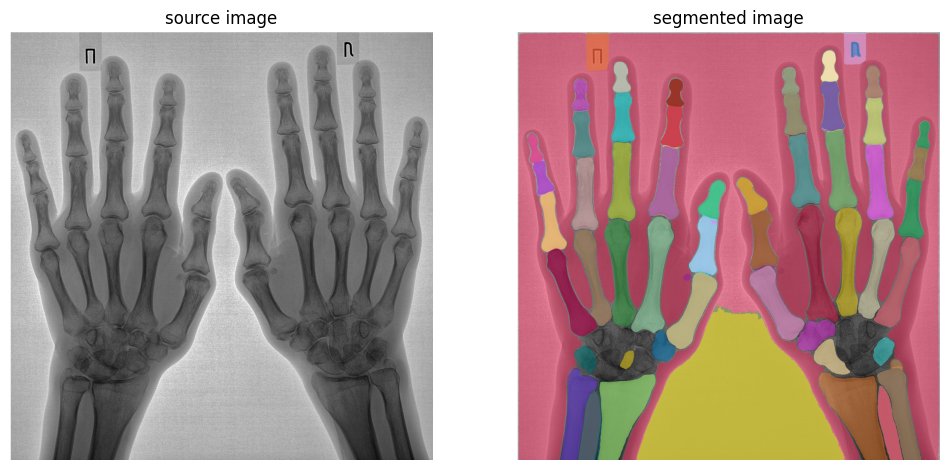

In [91]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Interaction with segmentation results

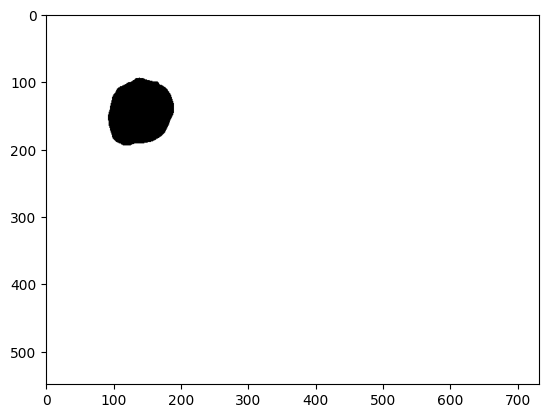

In [48]:
import matplotlib.pyplot as plt
plt.imshow(masks[1], cmap='binary');

# 3. Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

## Draw Box



**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [57]:
# !pip install jupyter_bbox_widget

In [70]:
IMAGE_NAME = 'berries.png'
IMAGE_PATH = home / 'sam_example' / 'images' / IMAGE_NAME

In [71]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [72]:
widget.bboxes

[{'x': 385, 'y': 53, 'width': 145, 'height': 146, 'label': ''},
 {'x': 574, 'y': 336, 'width': 126, 'height': 119, 'label': ''}]

## Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [73]:
image_bgr = cv2.imread(str(IMAGE_PATH))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


mask_predictor = SamPredictor(sam)
mask_predictor.set_image(image_rgb)

In [82]:
import numpy as np

box = widget.bboxes[0]
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']
])

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

## Results visualisation with Supervision

3
[5535 4478 4488]


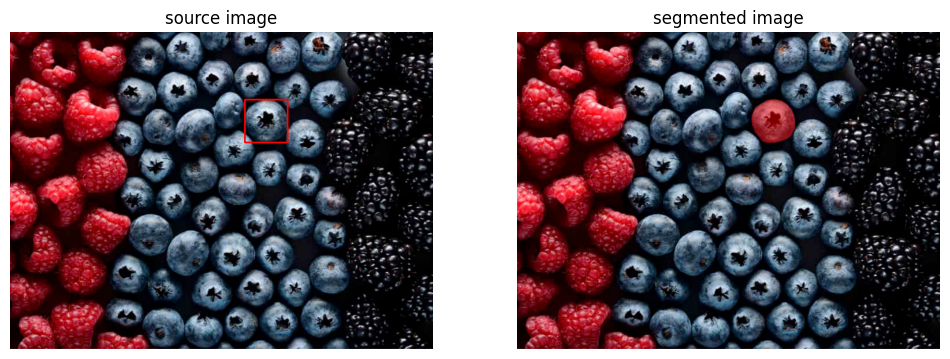

In [86]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)

print(len(detections))
print(detections.area)

detections = detections[detections.area == np.min(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Interaction with segmentation results

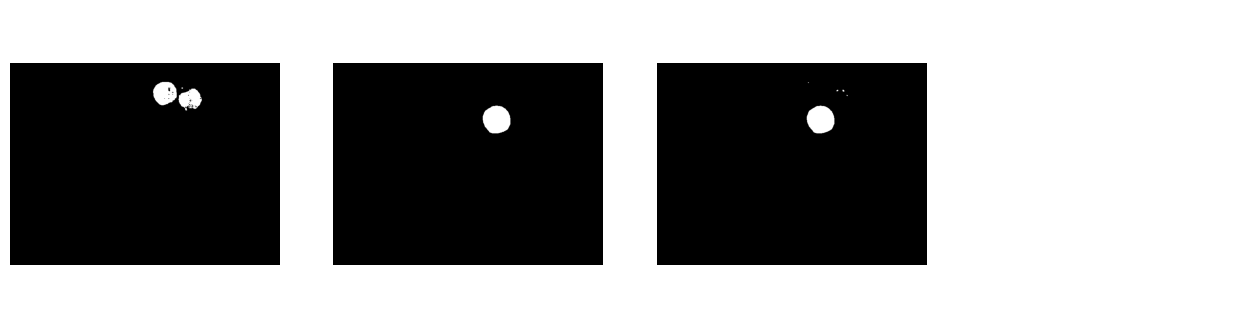

In [87]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

# Run multiple prompts on a single image


**NOTE:** `SamPredictor` object has two methods: 
 - `set_image()` is a expensive and relatively slow feature generator (ViT based)
 - `predict()` is a lightweight and fast mask generator
 
 you only run `set_image()` once, after which you can run `predict()` with different prompts.

In [67]:
%%timeit

mask_predictor.set_image(image_rgb)

2.27 s ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [68]:
%%timeit

mask, _, _ = mask_predictor.predict(
    box=box,
    multimask_output=False
)

6.58 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
